# Vsebina projektne naloge

Cilj projektne naloge je uporabiti in dodatno nadgraditi znanja, ki ste jih osvojili tekom izdelave sprotnih nalog. V sklopu projektne naloge se boste spoprijeli z izzivom regresijskega problema, natančneje z napovedovanjem časovnih vrst. V tem primeru bo šlo za realne meritve kvalitete zraka, vaš cilj pa bo čim natančneje napovedati vrednost parametra pm10.

In [1336]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import boxcox, yeojohnson
from matplotlib import pyplot as plt
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, explained_variance_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.wrappers.scikit_learn import KerasRegressor

In [1337]:
df = pd.read_csv('data/RV2_UPP_IIR_SIPIA.csv')

In [1338]:
df['Date'] = pd.to_datetime(df['Date']).dt.strftime('%Y-%m-%d %H:%M:%S')
df.sort_values(by="Date", inplace=True)

In [1339]:
df.head()

,Date,Latitude,Longitude,Altitude,NO2,PM2.5,O3,PM10
72,2023-02-15 19:35:00,46.5592,15.656191,270.0,47.0,47.0,0,56.0
78,2023-02-15 20:15:00,46.5592,15.656191,270.0,40.0,49.0,0,56.0
79,2023-02-15 20:35:00,46.5592,15.656191,270.0,40.0,49.0,0,56.0
153,2023-02-15 21:15:00,46.5592,15.656191,270.0,31.0,44.0,0,49.0
154,2023-02-15 21:35:00,46.5592,15.656191,270.0,31.0,44.0,0,49.0


In [1340]:
df.tail()

,Date,Latitude,Longitude,Altitude,NO2,PM2.5,O3,PM10
1880,2023-12-11 04:35:00,46.5592,15.656191,270.0,27.0,19.0,0,20.0
2633,2023-12-11 05:35:00,46.5592,15.656191,270.0,29.0,15.0,0,16.0
3067,2023-12-11 06:35:00,46.5592,15.656191,270.0,28.0,12.0,0,13.0
3548,2023-12-11 07:35:00,46.5592,15.656191,270.0,33.0,9.0,0,11.0
3844,2023-12-11 08:35:00,46.5592,15.656191,270.0,39.0,8.0,0,10.0


In [1341]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5625 entries, 72 to 3844
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       5625 non-null   object 
 1   Latitude   5625 non-null   float64
 2   Longitude  5625 non-null   float64
 3   Altitude   5625 non-null   float64
 4   NO2        5339 non-null   float64
 5   PM2.5      5160 non-null   float64
 6   O3         5625 non-null   int64  
 7   PM10       5159 non-null   float64
dtypes: float64(6), int64(1), object(1)
memory usage: 395.5+ KB


In [1342]:
df_weather = pd.read_csv('data/weather.csv')
df_weather.head()

,Date,temperature_2m (°C),relative_humidity_2m (%),dew_point_2m (°C),apparent_temperature (°C),precipitation (mm),rain (mm),snowfall (cm),surface_pressure (hPa),cloud_cover (%),wind_speed_10m (km/h),wind_direction_10m (°),soil_temperature_0_to_7cm (°C),soil_moisture_0_to_7cm (m³/m³),is_day ()
0,2023-01-01 00:15:00,7.7,85.0,5.3,5.5,0.0,0.0,0.0,992.7,7.0,6.7,144.0,2.6,0.357,0.0
1,2023-01-01 00:35:00,7.7,85.0,5.3,5.5,0.0,0.0,0.0,992.7,7.0,6.7,144.0,2.6,0.357,0.0
2,2023-01-01 01:15:00,7.8,84.0,5.2,5.7,0.0,0.0,0.0,992.8,4.0,6.4,133.0,2.1,0.356,0.0
3,2023-01-01 01:35:00,7.8,84.0,5.2,5.7,0.0,0.0,0.0,992.8,4.0,6.4,133.0,2.1,0.356,0.0
4,2023-01-01 02:15:00,4.8,92.0,3.6,1.9,0.0,0.0,0.0,992.5,10.0,9.2,141.0,1.8,0.356,0.0


In [1343]:
df = pd.merge(df, df_weather, on='Date', how='left')
df.head()

,Date,Latitude,Longitude,Altitude,NO2,PM2.5,O3,PM10,temperature_2m (°C),relative_humidity_2m (%),...,precipitation (mm),rain (mm),snowfall (cm),surface_pressure (hPa),cloud_cover (%),wind_speed_10m (km/h),wind_direction_10m (°),soil_temperature_0_to_7cm (°C),soil_moisture_0_to_7cm (m³/m³),is_day ()
0,2023-02-15 19:35:00,46.5592,15.656191,270.0,47.0,47.0,0,56.0,0.5,91.0,...,0.0,0.0,0.0,996.8,0.0,8.0,190.0,0.4,0.348,0.0
1,2023-02-15 20:15:00,46.5592,15.656191,270.0,40.0,49.0,0,56.0,0.1,92.0,...,0.0,0.0,0.0,996.8,0.0,5.9,227.0,0.2,0.348,0.0
2,2023-02-15 20:35:00,46.5592,15.656191,270.0,40.0,49.0,0,56.0,0.1,92.0,...,0.0,0.0,0.0,996.8,0.0,5.9,227.0,0.2,0.348,0.0
3,2023-02-15 21:15:00,46.5592,15.656191,270.0,31.0,44.0,0,49.0,-1.1,93.0,...,0.0,0.0,0.0,996.6,0.0,4.6,252.0,0.1,0.348,0.0
4,2023-02-15 21:35:00,46.5592,15.656191,270.0,31.0,44.0,0,49.0,-1.1,93.0,...,0.0,0.0,0.0,996.6,0.0,4.6,252.0,0.1,0.348,0.0


# Predprocesiranje podatkov

Zapolnjevanje manjkajočih vrednosti 

In [1344]:
df.isnull().sum()

Date                                0
Latitude                            0
Longitude                           0
Altitude                            0
NO2                               286
PM2.5                             465
O3                                  0
PM10                              466
temperature_2m (°C)                 1
relative_humidity_2m (%)            1
dew_point_2m (°C)                   1
apparent_temperature (°C)           1
precipitation (mm)                  1
rain (mm)                           1
snowfall (cm)                       1
surface_pressure (hPa)              1
cloud_cover (%)                     1
wind_speed_10m (km/h)               1
wind_direction_10m (°)              1
soil_temperature_0_to_7cm (°C)      1
soil_moisture_0_to_7cm (m³/m³)      1
is_day ()                           1
dtype: int64

In [1345]:
cols_to_fill = df.columns[df.isnull().any()].tolist()
print(cols_to_fill)

['NO2', 'PM2.5', 'PM10', 'temperature_2m (°C)', 'relative_humidity_2m (%)', 'dew_point_2m (°C)', 'apparent_temperature (°C)', 'precipitation (mm)', 'rain (mm)', 'snowfall (cm)', 'surface_pressure (hPa)', 'cloud_cover (%)', 'wind_speed_10m (km/h)', 'wind_direction_10m (°)', 'soil_temperature_0_to_7cm (°C)', 'soil_moisture_0_to_7cm (m³/m³)', 'is_day ()']


In [1346]:
for col in cols_to_fill:
    incomplete_rows = df[df[col].isnull()]
    complete_rows = df[~df[col].isnull()]

    # Features and target columns excluding 'Date'
    features = [c for c in df.columns if c != col and c != 'Date']
    target = col

    X_train = complete_rows[features]
    y_train = complete_rows[target]

    model = HistGradientBoostingRegressor()

    model.fit(X_train, y_train)

    predicted_values = model.predict(incomplete_rows[features])

    df.loc[df[col].isnull(), col] = predicted_values

In [1347]:
df.isnull().sum()

Date                              0
Latitude                          0
Longitude                         0
Altitude                          0
NO2                               0
PM2.5                             0
O3                                0
PM10                              0
temperature_2m (°C)               0
relative_humidity_2m (%)          0
dew_point_2m (°C)                 0
apparent_temperature (°C)         0
precipitation (mm)                0
rain (mm)                         0
snowfall (cm)                     0
surface_pressure (hPa)            0
cloud_cover (%)                   0
wind_speed_10m (km/h)             0
wind_direction_10m (°)            0
soil_temperature_0_to_7cm (°C)    0
soil_moisture_0_to_7cm (m³/m³)    0
is_day ()                         0
dtype: int64

# Informations gain

In [1348]:
output_col = 'PM10'

input_cols = df.columns.tolist()
input_cols.remove(output_col)
input_cols.remove('Date')

information_gain_scores = mutual_info_regression(df[input_cols], df[output_col])

feature_importances = pd.Series(information_gain_scores, index=input_cols)
feature_importances.name = 'Information Gain Scores'
feature_importances.sort_values(ascending=False, inplace=True)

feature_importances.head(10)

PM2.5                             1.281073
soil_moisture_0_to_7cm (m³/m³)    0.439451
soil_temperature_0_to_7cm (°C)    0.282955
apparent_temperature (°C)         0.268999
dew_point_2m (°C)                 0.261344
surface_pressure (hPa)            0.259102
NO2                               0.255985
temperature_2m (°C)               0.239397
wind_direction_10m (°)            0.176565
wind_speed_10m (km/h)             0.150512
Name: Information Gain Scores, dtype: float64

<Axes: >

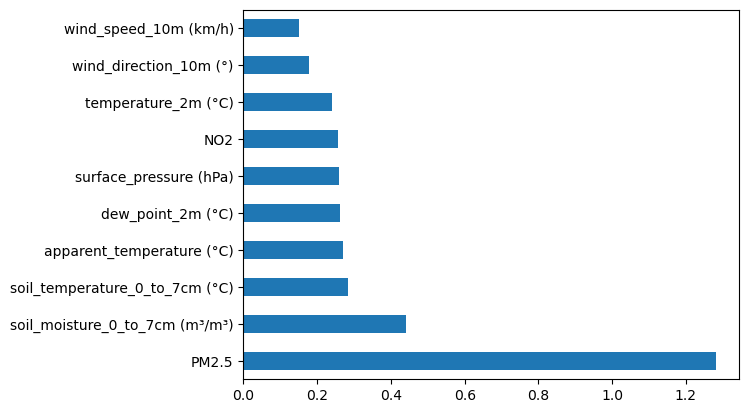

In [1349]:
feature_importances.head(10).plot.barh()

Transformacija podatkov

In [1350]:
def boxcox_transform(column):
    # create before and after plots for comparison
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    sns.distplot(df[column], ax=ax[0])
    ax[0].set_title("Before Box-Cox")

    # transform data
    data = boxcox(df[column], lmbda=0.0)

    # create after plots
    sns.distplot(data, ax=ax[1])
    ax[1].set_title("After Box-Cox")

    # update dataframe
    df[column] = data

    plt.show()


In [1351]:
def yeojohnson_transform(column):
    # create before and after plots for comparison
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    sns.distplot(df[column], ax=ax[0])
    ax[0].set_title("Before Yeo-Johnson")

    # transform data
    data = yeojohnson(df[column])

    # create after plots
    sns.distplot(data[0], ax=ax[1])
    ax[1].set_title("After Yeo-Johnson")

    # update dataframe
    df[column] = data[0]

    plt.show()

/var/folders/m7/dkyjm7gn71ggjt2b8p3ymthc0000gn/T/ipykernel_34006/3321678299.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column], ax=ax[0])
/opt/homebrew/Caskroom/miniforge/base/envs/rnn/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/var/folders/m7/dkyjm7gn71ggjt2b8p3ymthc0000gn/T/ipykernel_34006/3321678299.py:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code t

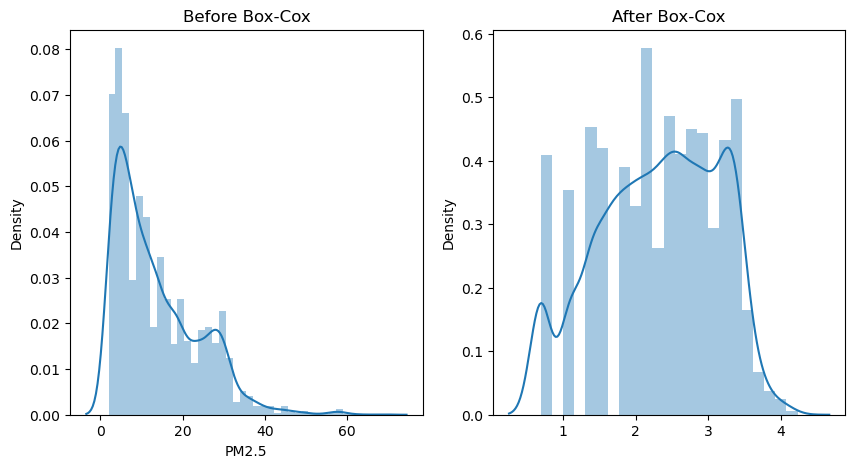

In [1352]:
boxcox_transform('PM2.5')

/var/folders/m7/dkyjm7gn71ggjt2b8p3ymthc0000gn/T/ipykernel_34006/3321678299.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column], ax=ax[0])
/opt/homebrew/Caskroom/miniforge/base/envs/rnn/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/var/folders/m7/dkyjm7gn71ggjt2b8p3ymthc0000gn/T/ipykernel_34006/3321678299.py:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code t

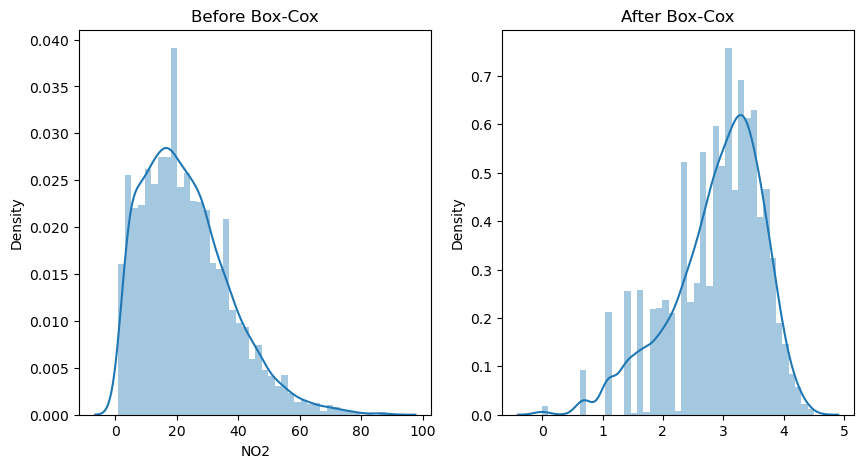

In [1353]:
boxcox_transform('NO2')

/var/folders/m7/dkyjm7gn71ggjt2b8p3ymthc0000gn/T/ipykernel_34006/3321678299.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column], ax=ax[0])
/opt/homebrew/Caskroom/miniforge/base/envs/rnn/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/var/folders/m7/dkyjm7gn71ggjt2b8p3ymthc0000gn/T/ipykernel_34006/3321678299.py:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code t

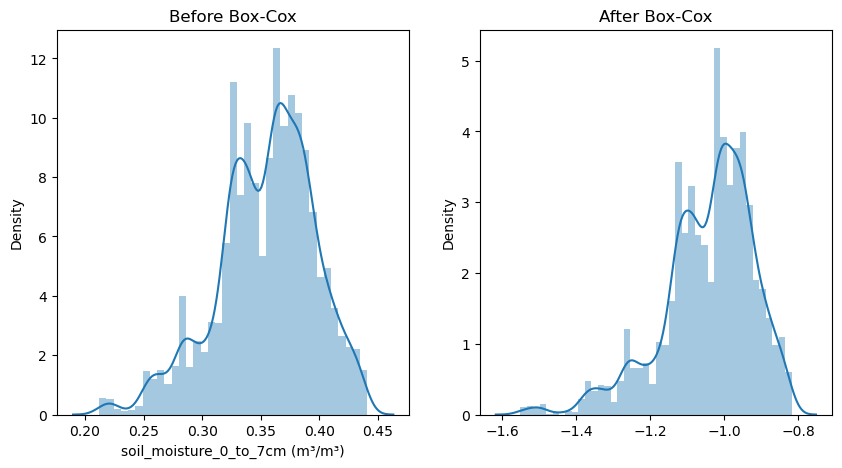

In [1354]:
boxcox_transform("soil_moisture_0_to_7cm (m³/m³)")

/var/folders/m7/dkyjm7gn71ggjt2b8p3ymthc0000gn/T/ipykernel_34006/2935021008.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column], ax=ax[0])
/opt/homebrew/Caskroom/miniforge/base/envs/rnn/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/var/folders/m7/dkyjm7gn71ggjt2b8p3ymthc0000gn/T/ipykernel_34006/2935021008.py:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code t

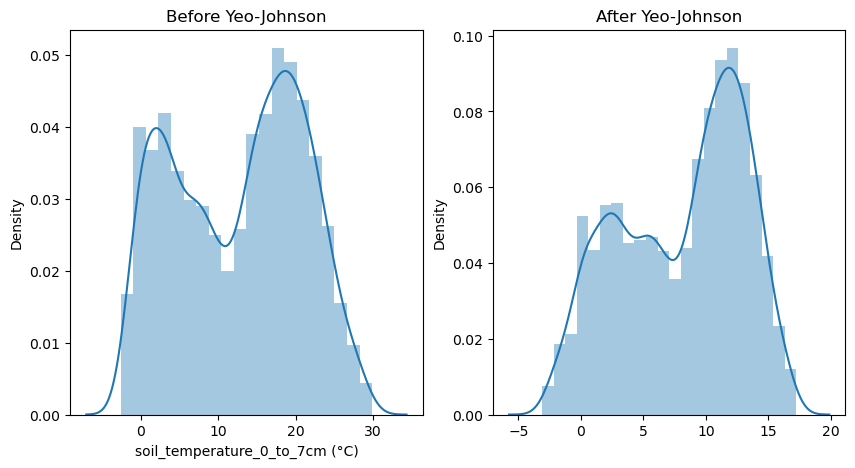

In [1355]:
yeojohnson_transform("soil_temperature_0_to_7cm (°C)")

/var/folders/m7/dkyjm7gn71ggjt2b8p3ymthc0000gn/T/ipykernel_34006/2935021008.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column], ax=ax[0])
/opt/homebrew/Caskroom/miniforge/base/envs/rnn/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/var/folders/m7/dkyjm7gn71ggjt2b8p3ymthc0000gn/T/ipykernel_34006/2935021008.py:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code t

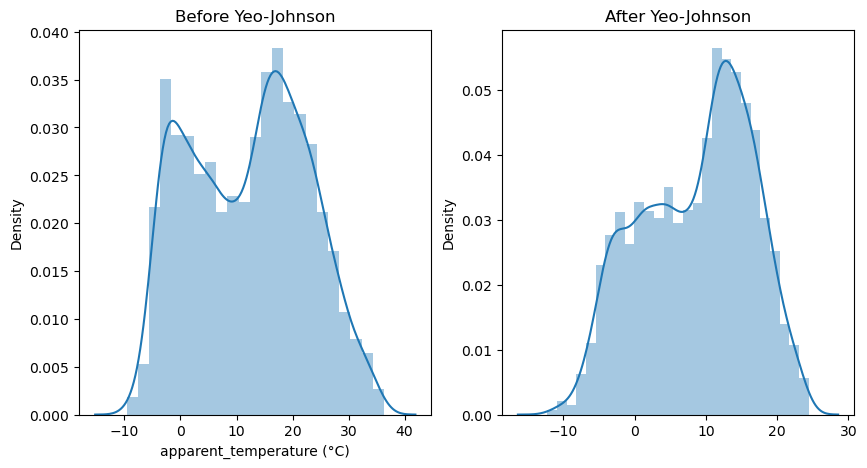

In [1356]:
yeojohnson_transform("apparent_temperature (°C)")

/var/folders/m7/dkyjm7gn71ggjt2b8p3ymthc0000gn/T/ipykernel_34006/2935021008.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column], ax=ax[0])
/opt/homebrew/Caskroom/miniforge/base/envs/rnn/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/var/folders/m7/dkyjm7gn71ggjt2b8p3ymthc0000gn/T/ipykernel_34006/2935021008.py:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code t

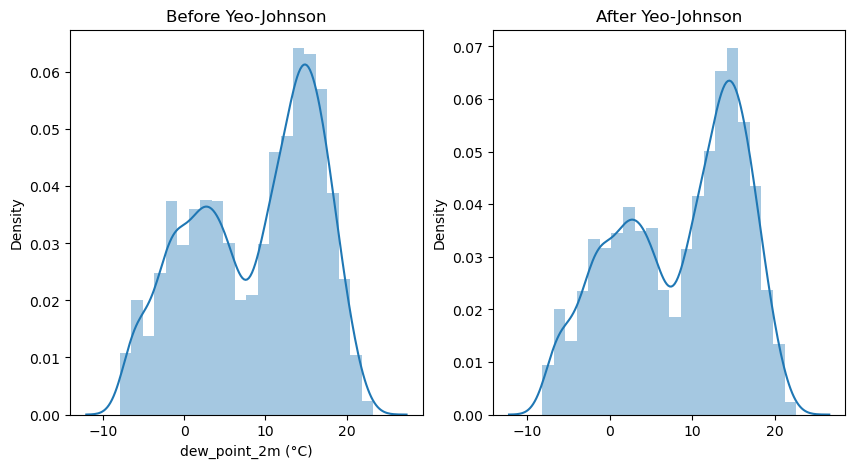

In [1357]:
yeojohnson_transform("dew_point_2m (°C)")

/var/folders/m7/dkyjm7gn71ggjt2b8p3ymthc0000gn/T/ipykernel_34006/3321678299.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column], ax=ax[0])
/opt/homebrew/Caskroom/miniforge/base/envs/rnn/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/var/folders/m7/dkyjm7gn71ggjt2b8p3ymthc0000gn/T/ipykernel_34006/3321678299.py:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code t

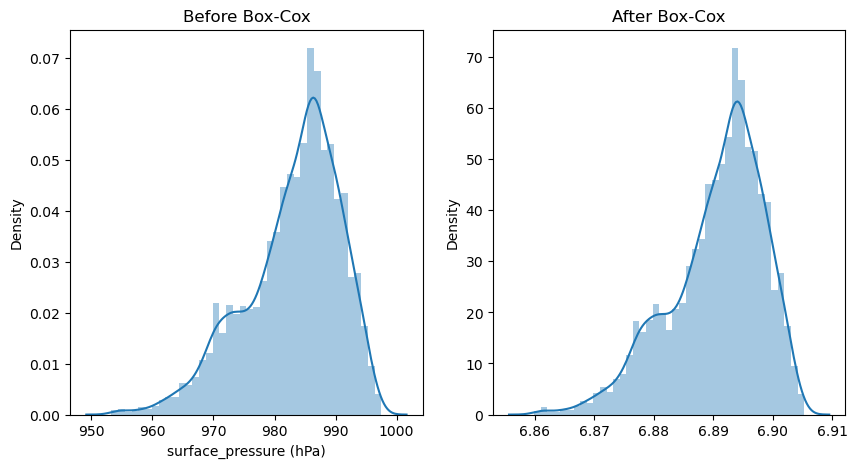

In [1358]:
boxcox_transform("surface_pressure (hPa)")

## Normalizacija/Standardizacija podatkov

**When to Use:**
- Use standardization when the distribution of your data is Gaussian-like and you have features with different units or different scales. It's robust to outliers and doesn't bound values to a specific range.

- Use normalization when your data doesn't follow a Gaussian distribution, or when you're working with algorithms that require data in a specific range (like neural networks).

In [1359]:
columns_to_normalize = ['PM2.5', 'NO2']
columns_to_standardize = ['soil_moisture_0_to_7cm (m³/m³)', 'soil_temperature_0_to_7cm (°C)',
                          'apparent_temperature (°C)', 'dew_point_2m (°C)', 'surface_pressure (hPa)']

min_max_scaler = MinMaxScaler()
standard_scaler = StandardScaler()

df[columns_to_normalize] = min_max_scaler.fit_transform(df[columns_to_normalize])
df[columns_to_standardize] = standard_scaler.fit_transform(df[columns_to_standardize])

# Izdelava modela

In [1360]:
target_variable = 'PM10'

features = columns_to_normalize + columns_to_standardize
selected_features = features + [target_variable]

data = df[selected_features]

In [1361]:
def create_time_series(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i + sequence_length, :-1])  # Features
        y.append(data[i + sequence_length, -1])  # Target variable
    return np.array(X), np.array(y)


In [1362]:
sequence_length = 48  # od 0:15 do 0:15 naslednjega dne je 48 meritev

In [1363]:
test_size = 0.2
train_data, test_data = train_test_split(data, test_size=test_size, shuffle=False)


In [1364]:
X_train, y_train = create_time_series(train_data.values, sequence_length)
X_test, y_test = create_time_series(test_data.values, sequence_length)

In [1365]:
def create_model(units=32, optimizer='adam', activation='relu', batch_size=32, epochs=10):
    model = Sequential()
    model.add(LSTM(units=units, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(LSTM(units=units))
    model.add(Dense(units=16, activation=activation))
    model.add(Dense(units=1))
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

In [1366]:
param_grid = {
    'units': [32, 64, 128],
    'optimizer': ['adam', 'rmsprop'],
    'activation': ['relu', 'sigmoid'],
    'batch_size': [32],
    'epochs': [10]
}

In [1367]:
model = KerasRegressor(build_fn=create_model, verbose=1)
grid = RandomizedSearchCV(estimator=model, param_distributions=param_grid,
                          scoring='neg_mean_squared_error', cv=3, n_iter=5,
                          random_state=1234)
grid_result = grid.fit(X_train, y_train, verbose=1)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Epoch 1/10


/var/folders/m7/dkyjm7gn71ggjt2b8p3ymthc0000gn/T/ipykernel_34006/3223854895.py:1: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_model, verbose=1)


93/93 [==============================] - 3s 20ms/step - loss: 471.5154
Epoch 2/10
93/93 [==============================] - 2s 20ms/step - loss: 426.9598
Epoch 3/10
93/93 [==============================] - 2s 20ms/step - loss: 398.1184
Epoch 4/10
93/93 [==============================] - 2s 20ms/step - loss: 372.1839
Epoch 5/10
93/93 [==============================] - 2s 20ms/step - loss: 348.6532
Epoch 6/10
93/93 [==============================] - 2s 20ms/step - loss: 327.3022
Epoch 7/10
93/93 [==============================] - 2s 20ms/step - loss: 307.9246
Epoch 8/10
93/93 [==============================] - 2s 20ms/step - loss: 290.3978
Epoch 9/10
93/93 [==============================] - 2s 20ms/step - loss: 274.5542
Epoch 10/10
47/47 [==============================] - 0s 5ms/step
Epoch 1/10
93/93 [==============================] - 3s 20ms/step - loss: 657.5031
Epoch 2/10
93/93 [==============================] - 2s 21ms/step - loss: 593.5449
Epoch 3/10
93/93 [==========================

In [1371]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))


Best: -149.366236 using {'units': 128, 'optimizer': 'adam', 'epochs': 10, 'batch_size': 32, 'activation': 'relu'}
-352.019501 (169.096520) with: {'units': 64, 'optimizer': 'adam', 'epochs': 10, 'batch_size': 32, 'activation': 'sigmoid'}
-332.843488 (105.226665) with: {'units': 128, 'optimizer': 'adam', 'epochs': 10, 'batch_size': 32, 'activation': 'sigmoid'}
-287.904012 (115.128485) with: {'units': 128, 'optimizer': 'rmsprop', 'epochs': 10, 'batch_size': 32, 'activation': 'sigmoid'}
-149.366236 (93.053610) with: {'units': 128, 'optimizer': 'adam', 'epochs': 10, 'batch_size': 32, 'activation': 'relu'}
-251.294493 (113.855399) with: {'units': 32, 'optimizer': 'rmsprop', 'epochs': 10, 'batch_size': 32, 'activation': 'sigmoid'}


In [1372]:
best_model = grid_result.best_estimator_.model

y_pred = best_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
evs = explained_variance_score(y_test, y_pred)

print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)
print("Explained Variance Score:", evs)

34/34 [==============================] - 1s 15ms/step
Mean Absolute Error: 9.024241541009475
Mean Squared Error: 129.91733831219113
Explained Variance Score: 0.4275355315424706
